# Precision Volatility Forecasting for Strategic Quote Placement in High-Frequency Trading

In [21]:
import os
import pandas as pd
import numpy as np
import random
import importlib

import models.util as util
importlib.reload(util)

<module 'models.util' from '/Users/kang/Projects/volatility-analysis/models/util.py'>

In [22]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)

# Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(snapshot_features_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

Rolling features: (833290, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000235,NaT
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000356,NaT
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000357,NaT
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000162,NaT
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000179,NaT


=== HAR-RV Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00010876
QLIKE: 0.6665
Directional Accuracy: 0.5070


/Users/kang/Projects/volatility-analysis/models/har_rv.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_pred"] = y_pred


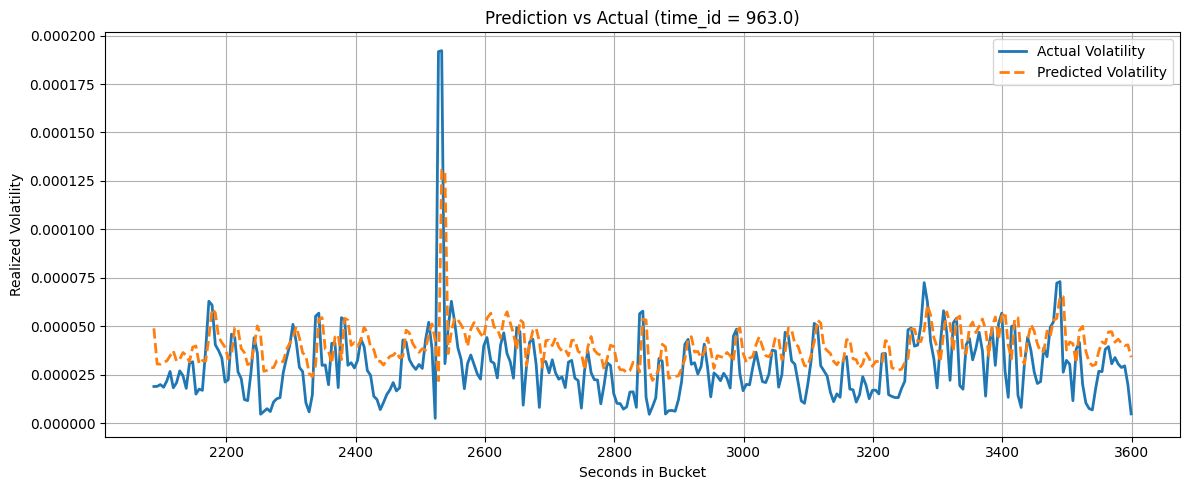

In [23]:
import models.har_rv as har_rv
importlib.reload(har_rv)

model_rv_ols, test_df_ols = har_rv.ols(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

=== HAR-RV WLS Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00011779
QLIKE: 0.8773
Directional Accuracy: 0.4819


/Users/kang/Projects/volatility-analysis/models/har_rv.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_pred"] = y_pred


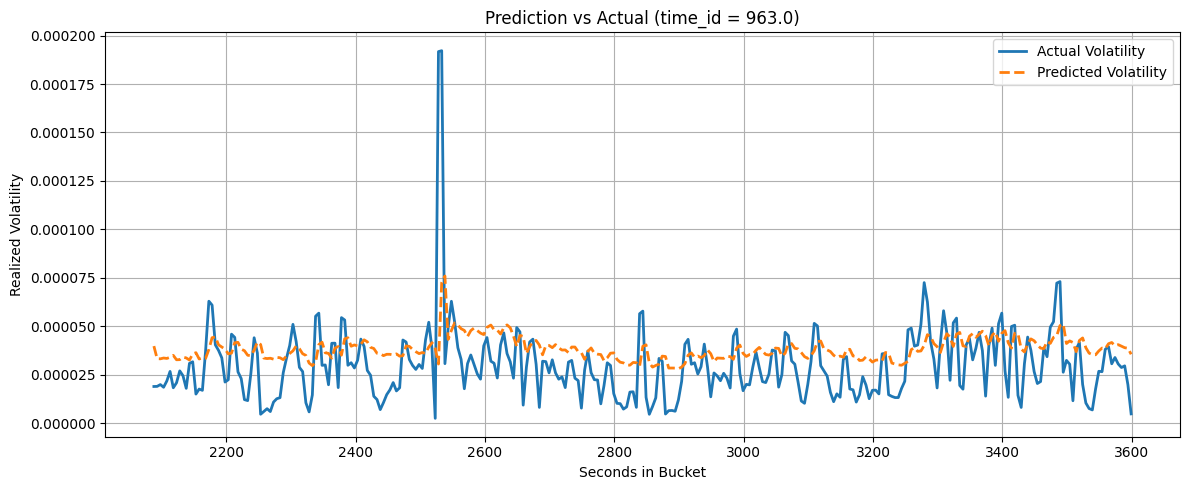

In [24]:
model_wls, test_df_wls = har_rv.wls(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_wls,
    time_id=test_df_wls['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

In [25]:
import models.lstm as lstm
importlib.reload(lstm)

subset_time_ids = snapshot_features_df['time_id'].unique()[:500]
df_subset = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()
lstm_df = util.generate_tick_sequences(df_subset, feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"])

In [26]:
importlib.reload(lstm)
model_lstm_baseline, history_lstm_baseline, test_df_lstm_baseline = lstm.baseline(lstm_df)

Epoch 1/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 247s 30ms/step - loss: 0.4836 - val_loss: 0.2737 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 243s 30ms/step - loss: 0.3741 - val_loss: 0.2479 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 244s 30ms/step - loss: 0.3711 - val_loss: 0.2078 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 245s 30ms/step - loss: 0.3707 - val_loss: 0.2416 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 245s 30ms/step - loss: 0.3699 - val_loss: 0.2067 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 246s 30ms/step - loss: 0.3664 - val_loss: 0.2178 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 246s 30ms/step - loss: 0.3631 - val_loss: 0.1966 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 246s 30ms/step - loss: 0.3612 - val_loss: 0.2189 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 247s 3

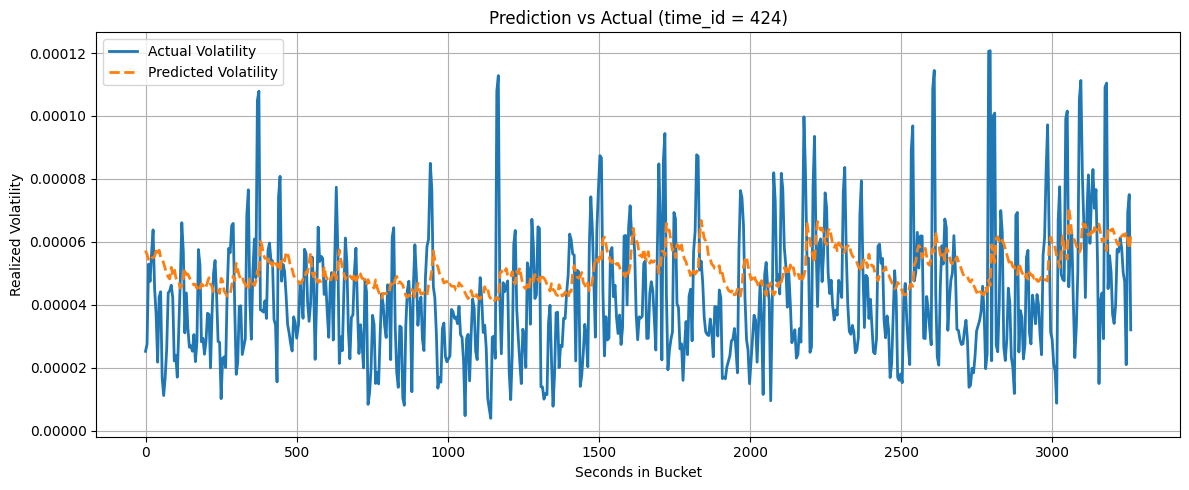

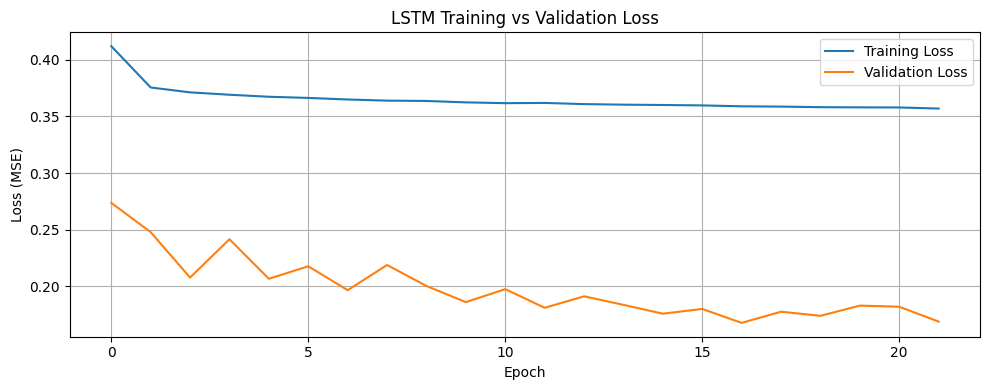

In [27]:
#test_df_lstm['time_id'].iloc[1]

util.plot_prediction_vs_actual(
    df=test_df_lstm_baseline,
    time_id=test_df_lstm_baseline['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_baseline)

In [28]:
model_lstm_v256d03, history_lstm_v256d03, test_df_lstm_v256d03 = lstm.config_v256d03(lstm_df)

Epoch 1/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 515s 63ms/step - loss: 0.4469 - val_loss: 0.2306 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 566s 69ms/step - loss: 0.3805 - val_loss: 0.2227 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 581s 71ms/step - loss: 0.3742 - val_loss: 0.2026 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 607s 74ms/step - loss: 0.3683 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 626s 77ms/step - loss: 0.3694 - val_loss: 0.1924 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 613s 75ms/step - loss: 0.3671 - val_loss: 0.2101 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 476s 58ms/step - loss: 0.3611 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 344s 42ms/step - loss: 0.3675 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 344s 4

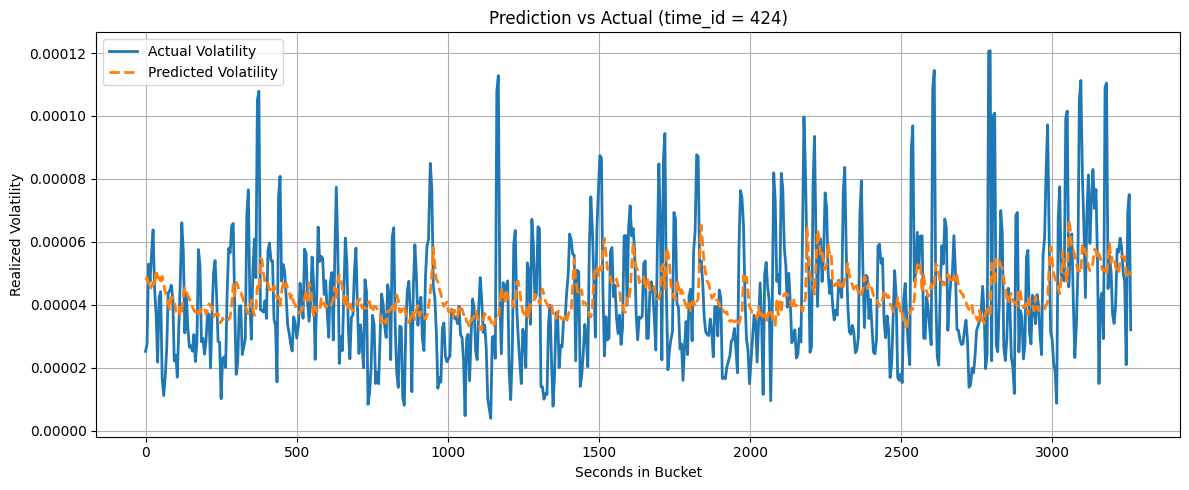

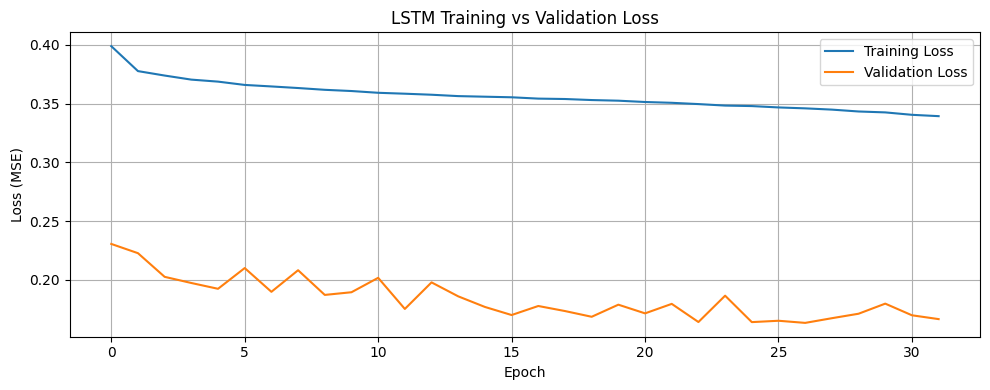

In [29]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_v256d03,
    time_id=test_df_lstm_v256d03['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_v256d03)

In [30]:
snapshot_more_feature_df = util.add_features(snapshot_features_df)
feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]


subset_time_ids = snapshot_more_feature_df['time_id'].unique()[:500]
df_subset = snapshot_more_feature_df[snapshot_more_feature_df['time_id'].isin(subset_time_ids)].copy()
lstm_df_more_feature = util.generate_tick_sequences(df_subset, feature_cols)

In [31]:
model_lstm_more_feature, history_lstm_more_feature, test_df_lstm_more_feature = lstm.config_v256d03(lstm_df_more_feature)

Epoch 1/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 1619s 198ms/step - loss: 0.4068 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 368s 45ms/step - loss: 0.3812 - val_loss: 0.2120 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 366s 45ms/step - loss: 0.3670 - val_loss: 0.2016 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 368s 45ms/step - loss: 0.3643 - val_loss: 0.2056 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 369s 45ms/step - loss: 0.3695 - val_loss: 0.1904 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 369s 45ms/step - loss: 0.3610 - val_loss: 0.1687 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 369s 45ms/step - loss: 0.3659 - val_loss: 0.1814 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 367s 45ms/step - loss: 0.3593 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 368s

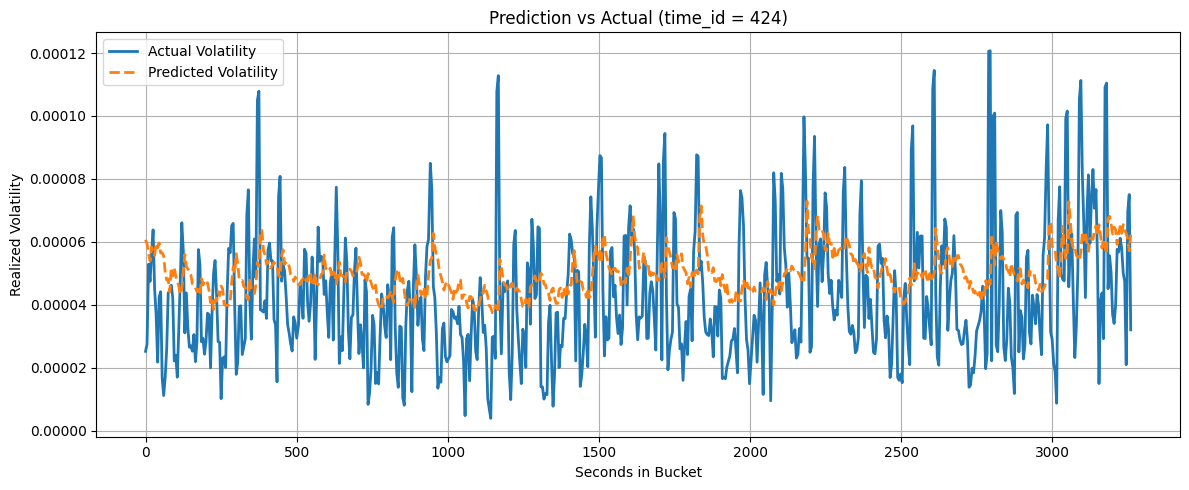

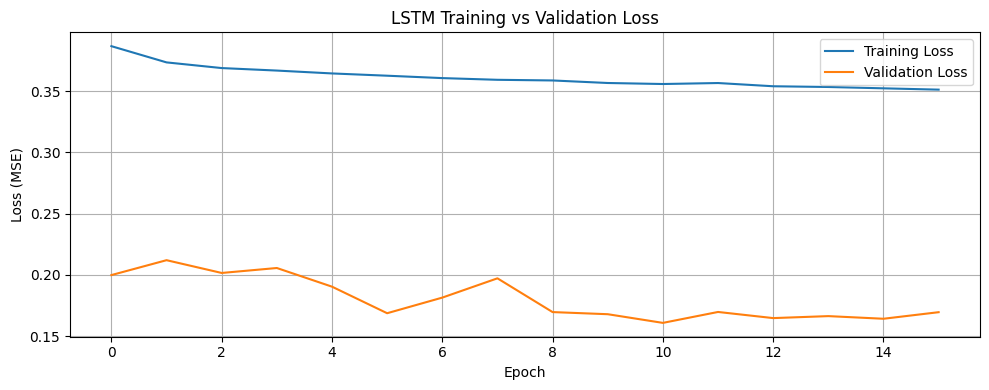

In [32]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_more_feature,
    time_id=test_df_lstm_more_feature['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_more_feature)